In [1]:
import numpy as np
import os
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import imageio

from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from kmapper.cover import Cover
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx
from community import best_partition # this is not part of networkx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio
import plotly
import plotly.graph_objs as go

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def rotation(image_array, degree):
    return sk.transform.rotate(image_array, degree)

def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    
def augmentation(folder_path,augmented_folder_path,num_unique_cells,angle_step):
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for cell in range(num_unique_cells):
        path = '%s/cell_%s' % (augmented_folder_path,cell)
        if not os.path.isdir(path): 
            os.mkdir(path)
        else:
            pass

#         print('Augmenting cell '+str(cell)+' in '+folder_path)
        image_path = images[cell]
        img = imageio.imread(image_path)
        rmin, rmax, cmin, cmax = bbox(img)
        image_to_transform = np.pad(img[rmin:rmax,cmin:cmax], 2, pad_with, padder=0)  

        rotation_angle = 0
        transformed_image = None
        while rotation_angle <= 360:
            transformed_image = rotation(image_to_transform, rotation_angle)
            new_file_path = '%s/cell_%s/angle_%s.jpg' % (augmented_folder_path,cell,rotation_angle)
            io.imsave(new_file_path, transformed_image)
            transformed_image = horizontal_flip(transformed_image)
            new_file_path = '%s/cell_%s/angle_%s_flipped.jpg' % (augmented_folder_path,cell,rotation_angle)
            io.imsave(new_file_path, transformed_image)
            rotation_angle += angle_step

In [142]:
num_unique_cells = 200

'''Loading the training data as a pandas dataframe'''
widths = []
heights = []
target = []
directories = ['/home/garner1/Work/dataset/cellImages/training/augmented/Cancer',
               '/home/garner1/Work/dataset/cellImages/training/augmented/Immuno',
              '/home/garner1/Work/dataset/cellImages/training/augmented/Other']
'''Box each nucleus'''
cell_labels = []
target_id = 0
for directory in directories:
    target_id += 1
    cell_id = 0
    for cell in os.listdir(directory)[:num_unique_cells]:
        path = os.path.join(directory, cell)
        cell_id += 1
        for img in os.listdir(path):
            filename = os.path.join(path, img)
            img = imageio.imread(filename)
            rmin, rmax, cmin, cmax = bbox(img)
            width = rmax-rmin
            height = cmax-cmin
            widths.append(width)
            heights.append(height)
            target.append(target_id)    
            cell_labels.append(cell_id)
        
            
'''Resizing images to small boxes'''
Mwidths = max(widths)
Mheights = max(heights)
images = []
for directory in directories:
    for cell in os.listdir(directory)[:num_unique_cells]:
        path = os.path.join(directory, cell)
        for img in os.listdir(path):
            filename = os.path.join(path, img)
            img = imageio.imread(filename)
            rmin, rmax, cmin, cmax = bbox(img)
            padwidth = int(Mwidths-(rmax-rmin))
            padheight = int(Mheights-(cmax-cmin))
            newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
            images.append(newimg)

X_train = np.zeros((Mwidths*Mheights,len(images)))
for ind in range(len(images)): X_train[:,ind] = images[ind].flatten() # from 2D arrays to 1D arrays
X_train = X_train.transpose()

'''2D embedding'''
n_neighbors = 30
n_components = 2
%time trans = umap.UMAP(n_neighbors=n_neighbors,min_dist=0.0,n_components=n_components,random_state=42).fit(X_train)
y_train = np.asarray(target)

CPU times: user 7min 57s, sys: 36.2 s, total: 8min 33s
Wall time: 7min 15s


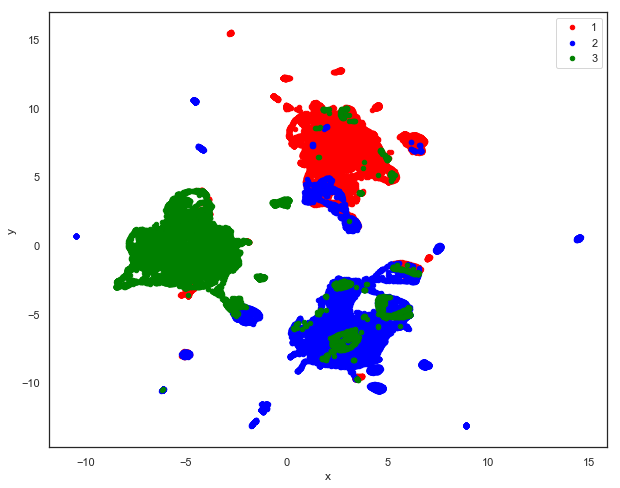

In [143]:
'''Create the dataframe'''
from pandas import DataFrame
df = DataFrame(dict(x=trans.embedding_[:,0], y=trans.embedding_[:,1], label=y_train))

'''Plot the expert labeled data'''
colors = {1:'red', 2:'blue', 3:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13



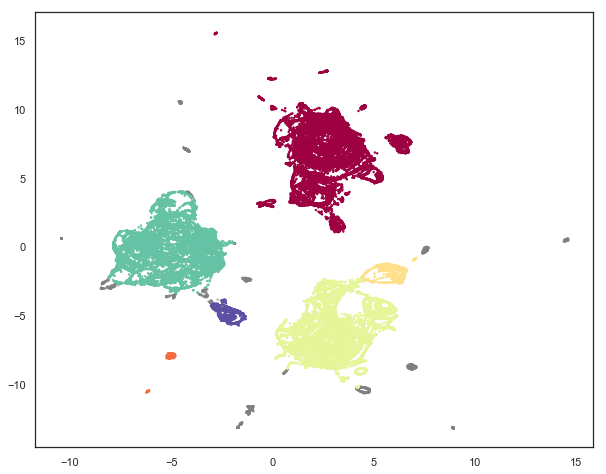

In [144]:
'''
HDBSCAN clusters in 2D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
'''
y_unsupervised = hdbscan.HDBSCAN(min_samples=None,min_cluster_size=550).fit_predict(trans.embedding_)
 
sns.set(style='white', rc={'figure.figsize':(10,8)})
clustered_train = (y_unsupervised >= 0)
plt.scatter(trans.embedding_[~clustered_train, 0],
            trans.embedding_[~clustered_train, 1],
            c=(0.5, 0.5, 0.5),s=2,alpha=0.5)
plt.scatter(trans.embedding_[clustered_train, 0],
            trans.embedding_[clustered_train, 1],
            c=y_unsupervised[clustered_train],s=2,cmap='Spectral');

In [158]:
'''Loading the new data'''
numb_new_cells = 5000
target = []
directory = '/home/garner1/Work/dataset/cellImages/image52/augmented'
'''Box each nucleus'''
cell_labels = []
target_id = 4
images = []
cell_id = 0
count = 0
total = 0
for cell in os.listdir(directory)[:]:
    path = os.path.join(directory, cell)
    cell_id += 1
    for img in os.listdir(path):
        filename = os.path.join(path, img)
        img = imageio.imread(filename)
        rmin, rmax, cmin, cmax = bbox(img)
        width = rmax-rmin
        height = cmax-cmin
        total += 1
        if width <= Mwidths:
            if height <= Mheights:
                padwidth = int(Mwidths-(rmax-rmin))
                padheight = int(Mheights-(cmax-cmin))
                newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
                images.append(newimg)
                target.append(target_id)    
                cell_labels.append(cell_id)
                count += 1
print count, total

X_new = np.zeros((Mwidths*Mheights,len(images)))
for ind in range(len(images)): 
    X_new[:,ind] = images[ind].flatten() # from 2D arrays to 1D arrays
    
X_new = X_new.transpose()

'''2D embedding'''
n_neighbors = 30
n_components = 2
%time new_embedding = trans.transform(X_new)

27776 27776
CPU times: user 23min 5s, sys: 2.07 s, total: 23min 7s
Wall time: 3min 44s


In [159]:
'''Train 2 classifiers on the expert labeled training data'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# svc = SVC().fit(trans.embedding_, y_unsupervised)
knn = KNeighborsClassifier().fit(trans.embedding_, y_unsupervised)

y_new = knn.predict(new_embedding)

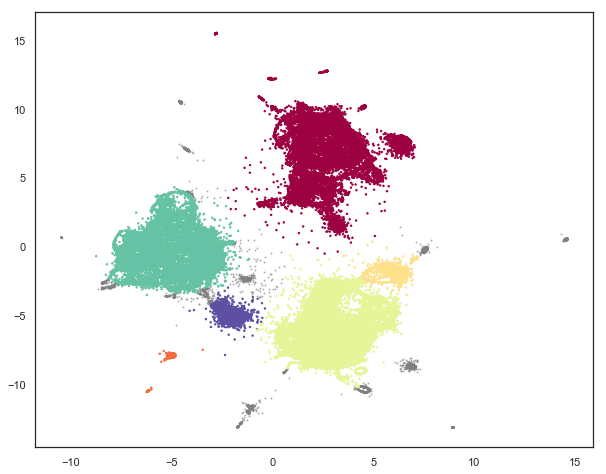

In [160]:
'''
HDBSCAN clusters in 2D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
'''
sns.set(style='white', rc={'figure.figsize':(10,8)})
clustered_new = (y_new >= 0)
clustered_train = (y_unsupervised >= 0)
plt.scatter(new_embedding[~clustered_new, 0],
            new_embedding[~clustered_new, 1],
            c=(0.5, 0.5, 0.5),s=1,alpha=0.5)
plt.scatter(new_embedding[clustered_new, 0],
            new_embedding[clustered_new, 1],
            c=y_new[clustered_new],s=2,cmap='Spectral')
plt.scatter(trans.embedding_[~clustered_train, 0],
            trans.embedding_[~clustered_train, 1],
            c=(0.5, 0.5, 0.5),s=1,alpha=0.5)
plt.scatter(trans.embedding_[clustered_train, 0],
            trans.embedding_[clustered_train, 1],
            c=y_unsupervised[clustered_train],s=2,cmap='Spectral')
plt.show()

In [161]:
import string 

def nochar(blabla):
    all = string.maketrans('','')
    nodigs = all.translate(all, string.digits)
    return blabla.translate(all, nodigs)

cell_ok = [-1]*len(cell_labels)
ind = 0
image_ids = []
for cell in os.listdir(directory)[:numb_new_cells]:
    path = os.path.join(directory, cell)
    for img in os.listdir(path):
        filename = os.path.join(path, img)
        img = imageio.imread(filename)
        rmin, rmax, cmin, cmax = bbox(img)
        width = rmax-rmin
        height = cmax-cmin
        image_ids.append(int(nochar(filename.split('/')[-2]))+1) #number cells adding 1 because id start from 0
        if width <= Mwidths:
            if height <= Mheights:
                cell_ok[ind] = 1
        ind += 1

In [162]:
List = zip(image_ids,list(y_new))

from collections import defaultdict
d = defaultdict(list)

for k, v in List: 
    d[k].append(v) #group the cluster_id by cell_id
# print(tuple(d.items()))  #these are sorted by cell_id value

from collections import Counter
cluster_id = []
for List in d.values():
    c = Counter(List)
    cluster_id.append(c.most_common(1)[0][0]) #these are sorted by cell_id value from 1 to numb_new_cells

# print cluster_id
clustered = (np.asarray(cluster_id)>=0)
# print np.asarray(cluster_id)[clustered]
# print np.asarray(d.keys())[clustered]

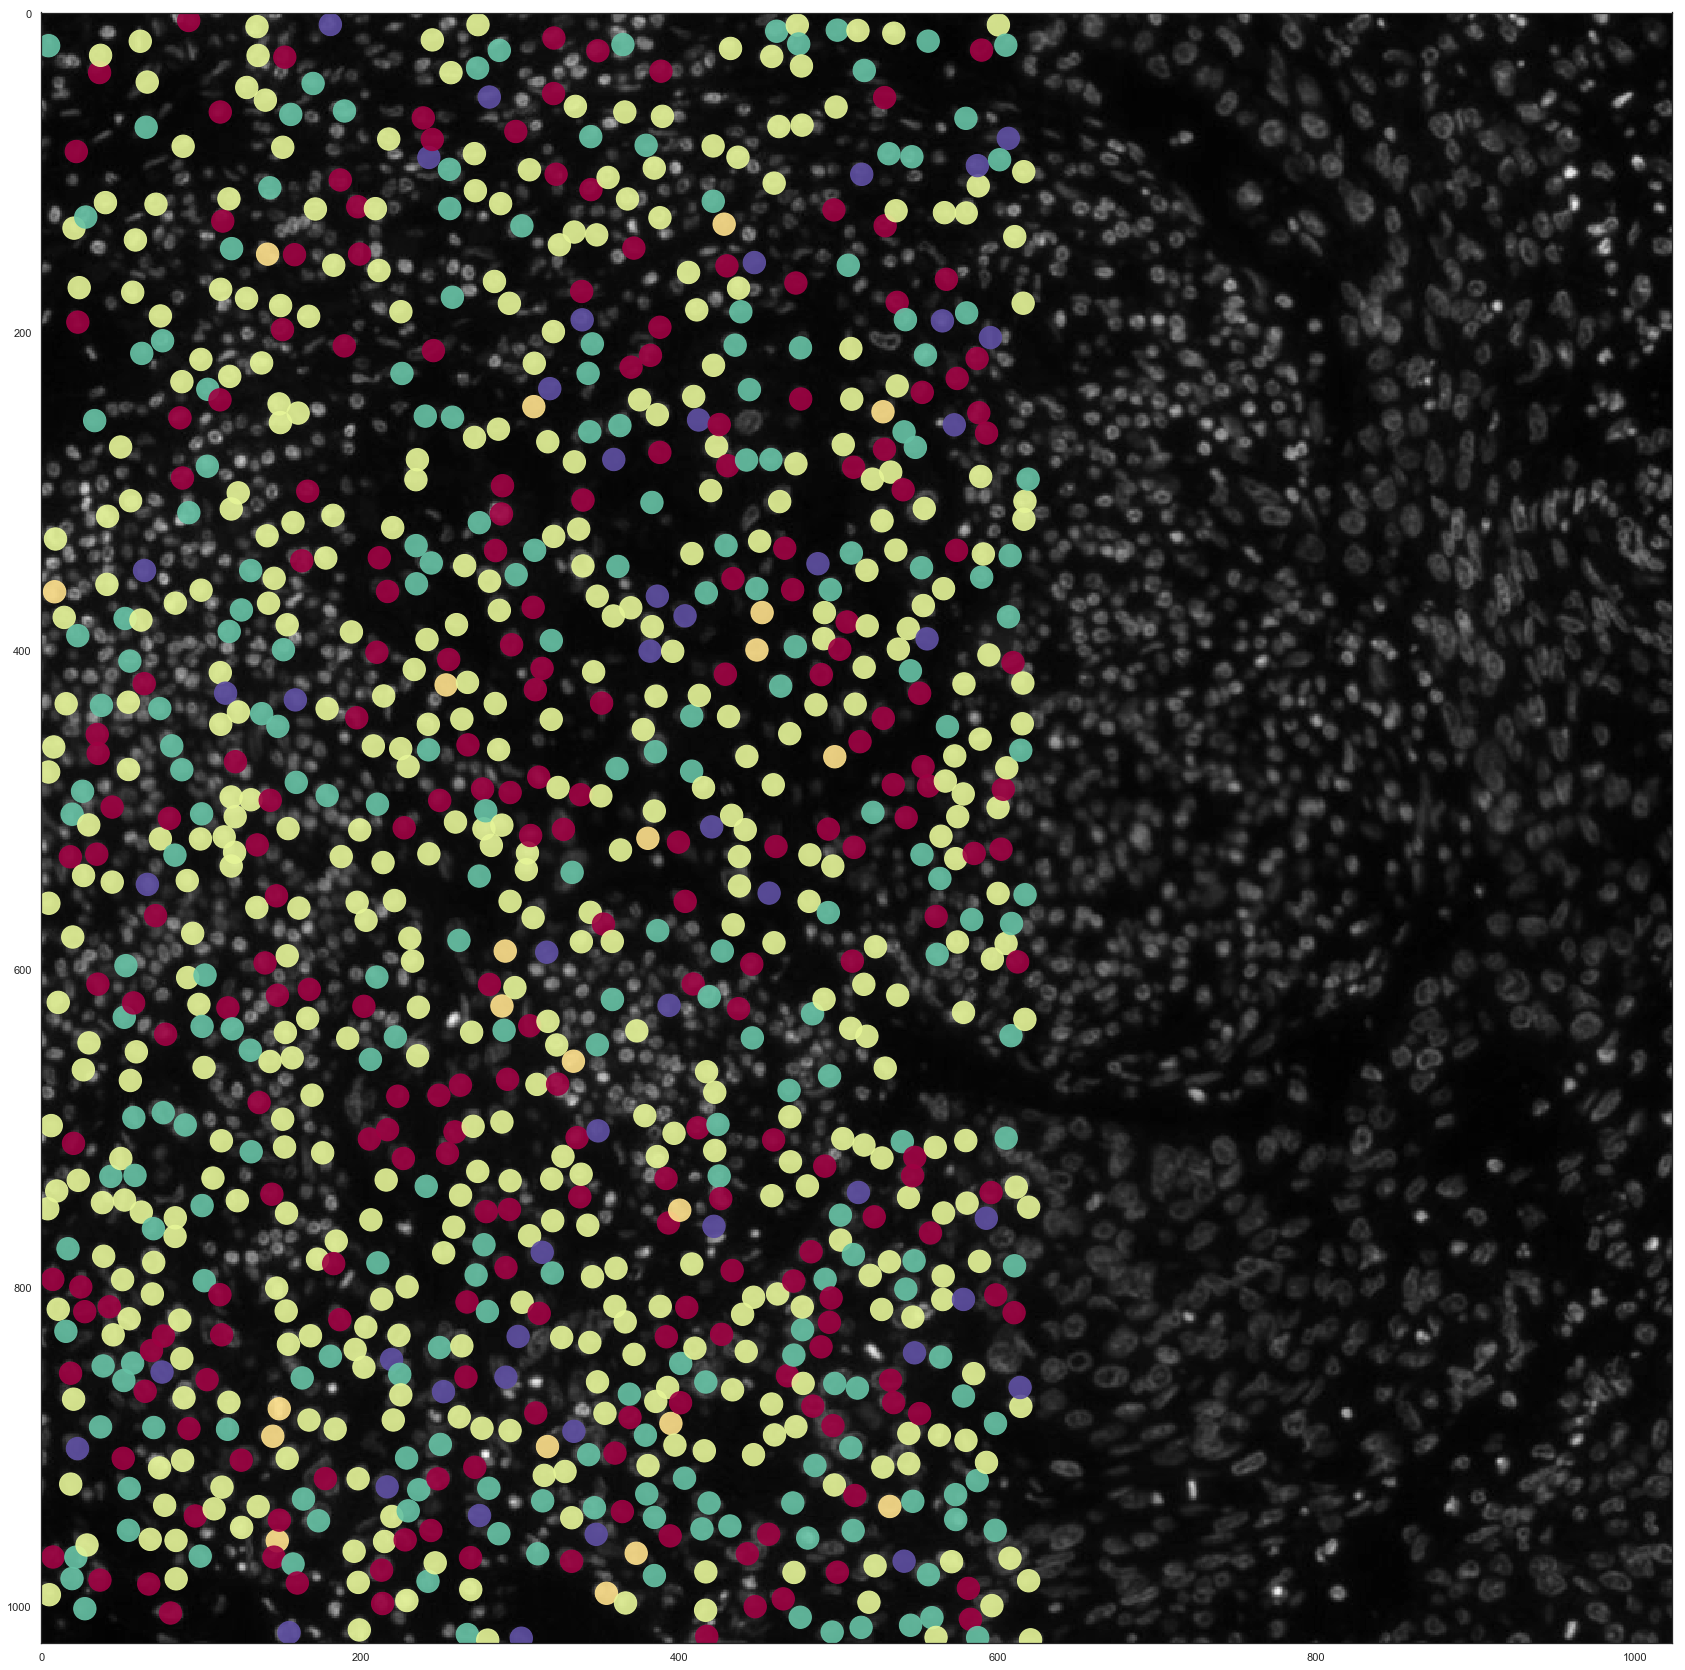

In [163]:
import csv
with open('/home/garner1/Work/dataset/cellImages/image52/properties.csv', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
properties = np.array(properties)

image = imageio.imread('/home/garner1/Work/dataset/cellImages/image52/iMS266_20190426_001.sub52.jpg')
sns.set(style='white', rc={'figure.figsize':(50,30)})

plt.scatter(properties[np.asarray(d.keys())[clustered],1].astype(np.float),
            properties[np.asarray(d.keys())[clustered],2].astype(np.float),
            c=np.asarray(cluster_id)[clustered],
            s=500,
            cmap='Spectral',
            alpha=0.9);
plt.imshow(image,cmap='gray')
plt.show()